# Estimate Optimal Savings Plan

This is an exploratory analysis intended to help me familiarize myself with the dataset. The goal is to evaluate whether historical usage patterns can be used to estimate the optimal size of a 1-year cloud savings plan. Methods and assumptions are intentionally simplified and not intended for production use.

## Problem

Given historical VM usage, can we pick a fixed number of reserved instances (via a 1-year savings plan) that minimizes total cost?

## Objective

Minimize total cost, assuming:

- Cost model:
  - Usage ≤ reserved amount → billed at 0.7 per VM (savings plan rate)
  - Usage > reserved amount → excess billed at 1.0 per VM (on-demand rate)
- A savings contract lasts one year

So, minimize Total cost, defined as:

Total Cost = ∑ [0.7×S + max(Uₕ − S, 0)]

Where:
- S is the size of the savings plan
- Uₕ is the VM utilization at a given time


## Assumptions

- Only 1-year savings plans are considered.
- Reserved VMs under a savings plan are 30% cheaper than on-demand VMs
- All usage not covered by the savings plan is billed at the on-demand rate.
- Usage is aggregated across instance types and regions for simplicity.

## Data Summary

- Daily seasonality is strong: usage drops at night.
- Weekly seasonality is strong: usage drops on weekends.
- There's some yearly seasonality: usage dips between Christmas and early January.
- Overall trend is increasing over time.
  - The ADF test doesn't find the unit root in the hourly data...
  - unless we increase the lag to at least 5 days (which slows down the test significantly)
- There is a strong correlation between the weekly VM usage and the optimal size of a savings plan for the following 365 days...
  - but once both series are detrended, the correlation disappears

## Conclusion
Given that:
- savings plans can only be 1- or 3-year long (in AWS)
- in one year intervals, the trend is much stronger than seasonality
- if the trend persists, the optimal savings plan size can be modelled as a linear function of time

Using this model, we could implement a strategy to purchase a new 1-year savings plan regularly (daily, weekly, or monthly), effectively creating a rolling savings plan ladder.

## Limitations
- Assumes fixed pricing: The model assumes constant savings plan and on-demand rates.
- Ignores instance type granularity: All usage is aggregated, treating all VMs as equivalent.
- Assumes linear trend continuation: The approach assumes the existing usage trend continues.
- Ignores 3-year plans: Only 1-year savings plans are considered.

---

# Descriptive statistics
## Trend

- We see an upward trend
  - ADF doesn't pick it up for hourly data (unless lag size is increased)
  - ADF picks it up for daily data

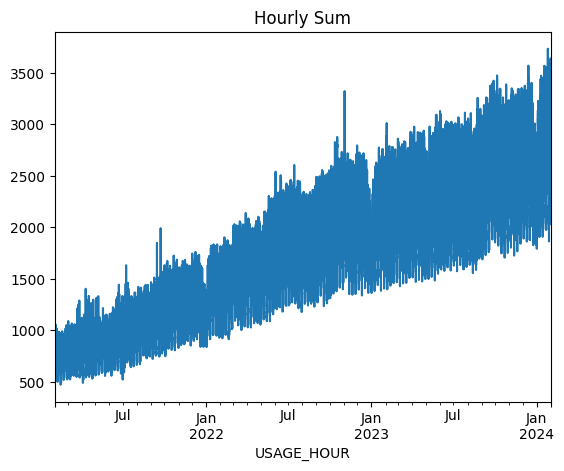

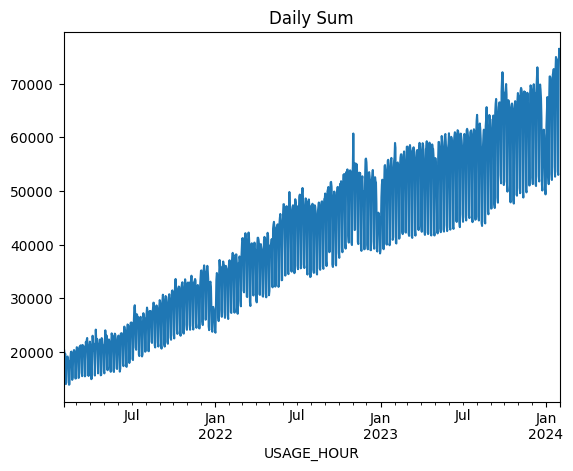

We clearly have a trend, but the Dickey-Fuller test doesnt pick it up in the hourly data:
ADF Statistic: -7.6923481972513805
p-value: 1.4083322117703174e-11
The unit root is clearer in the daily data:
ADF Statistic: -0.301898578729443
p-value: 0.9252350058931095


In [73]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

df = pd.read_parquet("hourly_normalized.parquet")
df['USAGE_DATE'] = df['USAGE_HOUR'].dt.date

hourly_sum = df.groupby('USAGE_HOUR')['NORM_USAGE'].sum()
daily_sum = hourly_sum.resample('D').sum()

hourly_sum.plot(title="Hourly Sum")
plt.show()

daily_sum.plot(title="Daily Sum")
plt.show()

result = adfuller(hourly_sum.dropna())
print('We clearly have a trend, but the Dickey-Fuller test doesn''t pick it up in the hourly data:')
print('ADF Statistic:', result[0])
print('p-value:', result[1])

print('The unit root is clearer in the daily data:')
result = adfuller(daily_sum.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])


---

## Seasonality
- We see strong daily seasonality in hourly data
- We see strong weekly seasonality in daily data

We see strong daily seasonality in hourly data:


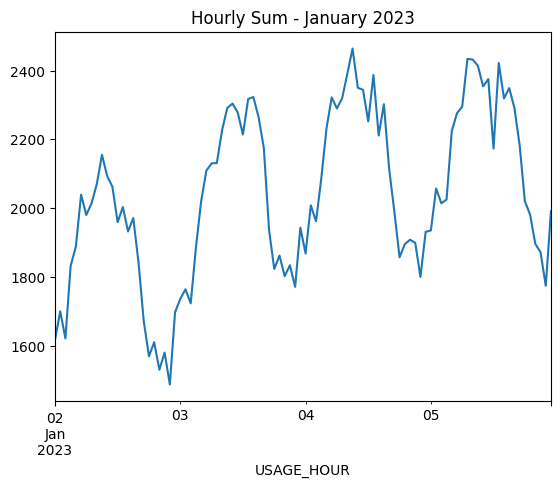

We see strong weekly seasonality in daily data:


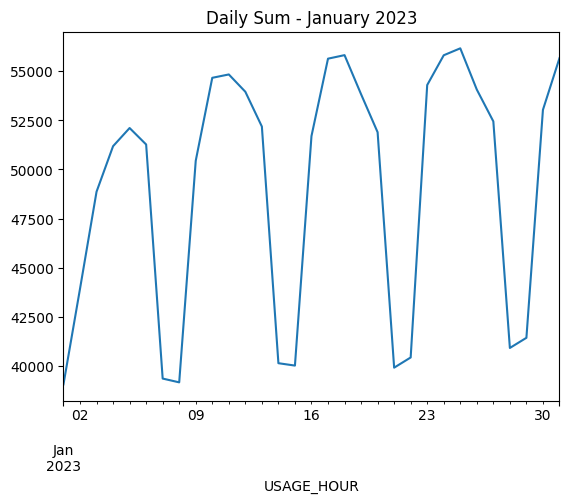

In [74]:
print('We see strong daily seasonality in hourly data:')
hourly_sum['2023-01-02':'2023-01-05'].plot(title="Hourly Sum - January 2023")
plt.show()

print('We see strong weekly seasonality in daily data:')
daily_sum['2023-01-01':'2023-01-31'].plot(title="Daily Sum - January 2023")
plt.show()

---

# Optimal savings plan
## Calculate the optimal savings plan, given the next 365 days of usage


In [77]:
import numpy as np
import pandas as pd

# Use ternary search to find the optimal savings plan
def optimum_savings_plan(hourly_sum, savings_plan_cost=0.7):
    def cost(threshold):
        return np.sum(
            threshold * savings_plan_cost +
            np.maximum(0, hourly_sum - threshold)
        )

    low = int(np.min(hourly_sum))
    high = int(np.max(hourly_sum))

    while high - low > 3:
        m1 = low + (high - low) // 3
        m2 = high - (high - low) // 3

        c1 = cost(m1)
        c2 = cost(m2)

        if c1 < c2:
            high = m2
        else:
            low = m1

    # Final pass: brute-force over remaining small range
    best_candidate = low
    best_cost = cost(low)
    for t in range(low + 1, high + 1):
        c = cost(t)
        if c < best_cost:
            best_cost = c
            best_candidate = t

    return best_candidate


df = pd.read_parquet("hourly_normalized.parquet")

# Compute hourly demand
hourly_sum = df.groupby('USAGE_HOUR')['NORM_USAGE'].sum()
hourly_sum = hourly_sum.asfreq('h')  # Fill gaps with NaN, which will be interpolated

# Now get daily demand
daily_sum = hourly_sum.resample('D').sum()

savings_plan_results_year = []

# For each day, compute the optimal number of savings plan VMs for the year starting that day (next 365 days)
# This can for sure be optimized, but for now it will suffice
for t in range(len(daily_sum)):
    day_start = daily_sum.index[t]
    
    # Extract exactly 24 hours of demand for the day
    demand_for_year = hourly_sum.loc[day_start : day_start + pd.Timedelta(days=364)]

    savings_plan_cost = 0.7  # Assume a 30% discount vs on-demand cost

    savings_plan_results_year.append(optimum_savings_plan(demand_for_year, savings_plan_cost))

savings_plan_df = pd.DataFrame({
    'USAGE_DATE': daily_sum.index,
    'savings_plan_vms_year': savings_plan_results_year
})

# Merge the savings plan data with the daily demand dataset
daily_sum_df = pd.DataFrame({
    'USAGE_DATE': daily_sum.index,
    'daily_demand': daily_sum.values
})

# Merge the two DataFrames on the 'USAGE_DATE' column
daily_sum_df = pd.merge(daily_sum_df, savings_plan_df, on='USAGE_DATE', how='left')

# Display the enriched dataset
print(daily_sum_df.head())


                 USAGE_DATE  daily_demand  savings_plan_vms_year
0 2021-02-01 00:00:00+00:00       19299.0                    874
1 2021-02-02 00:00:00+00:00       20460.0                    875
2 2021-02-03 00:00:00+00:00       19781.0                    877
3 2021-02-04 00:00:00+00:00       19736.0                    878
4 2021-02-05 00:00:00+00:00       19641.0                    880


---

## Calculate correlation between last week usage and the optimal savings plan for the next 365 days

Aggregating by week, we remove daily and weekly seasonality

Intercept: 366.3924
Coefficient: 0.0049
Mean Squared Error (MSE): 4043.2934
Mean Absolute Error (MAE): 45.9540
R^2 Score: 0.9690


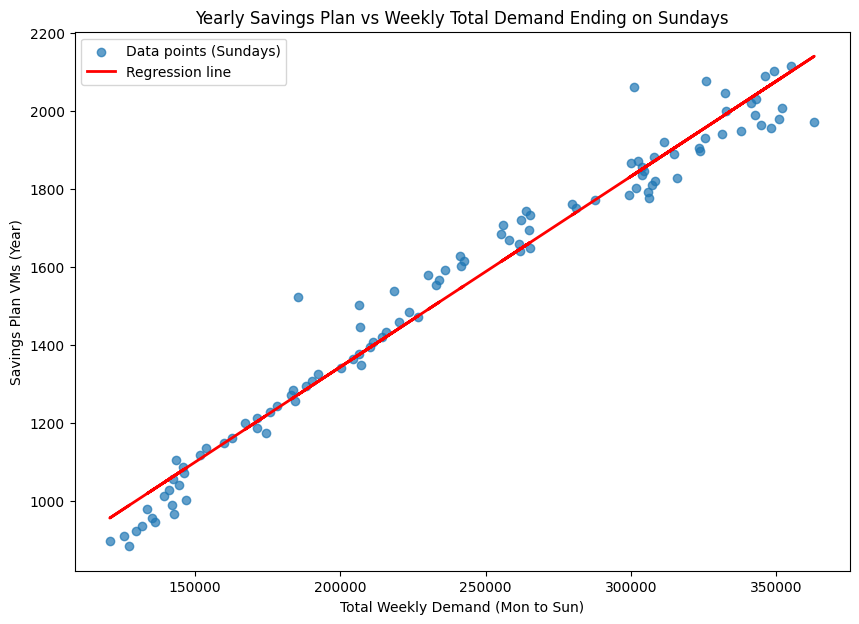

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure date column is datetime
daily_sum_df['USAGE_DATE'] = pd.to_datetime(daily_sum_df['USAGE_DATE'])
plot_df = daily_sum_df.iloc[:-365]

# Filter Sundays only (Sunday = 6)
sundays_df = plot_df[plot_df['USAGE_DATE'].dt.dayofweek == 6].copy()

# Compute weekly total demand for the week ending on each Sunday (previous Monday to Sunday)
weekly_total_demand = []

for date in sundays_df['USAGE_DATE']:
    # We take Monday (6 days before) to Sunday
    week_start = date - pd.Timedelta(days=6)
    mask = (plot_df['USAGE_DATE'] >= week_start) & (plot_df['USAGE_DATE'] <= date)

    weekly_sum = plot_df.loc[mask, 'daily_demand'].sum()
    weekly_total_demand.append(weekly_sum)

sundays_df['weekly_total_demand'] = weekly_total_demand

# Prepare data for regression and plotting
X = sundays_df['weekly_total_demand'].values.reshape(-1, 1)
y = sundays_df['savings_plan_vms_year'].values

# Fit linear regression
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Intercept: {model.intercept_:.4f}")
print(f"Coefficient: {model.coef_[0]:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R^2 Score: {r2:.4f}")

# Plot
plt.figure(figsize=(10, 7))
plt.scatter(X, y, alpha=0.7, label='Data points (Sundays)')
plt.plot(X, y_pred, color='red', linewidth=2, label='Regression line')

plt.xlabel('Total Weekly Demand (Mon to Sun)')
plt.ylabel('Savings Plan VMs (Year)')
plt.title('Yearly Savings Plan vs Weekly Total Demand Ending on Sundays')
plt.legend()
plt.show()


While there is a strong correlation between last week’s usage and the optimal savings plan size for the next 365 days, this relationship weakens significantly once both time series are de-trended. This suggests that the optimal savings plan size may be better modeled as a direct function of time, rather than short-term usage patterns.

=== Detrended Model Results ===
Intercept: 0.0000
Coefficient: 0.0001
Mean Squared Error (MSE): 1010.6103
Mean Absolute Error (MAE): 27.7461
R^2 Score: 0.0014


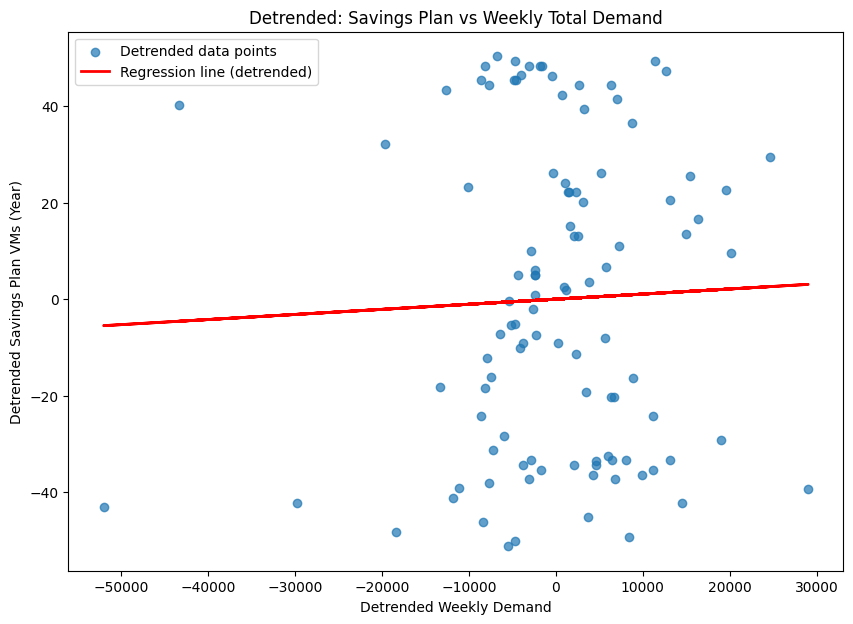

In [39]:
import numpy as np
from scipy.signal import detrend

# Time index for detrending (used for plotting and correlation check)
sundays_df['time_index'] = np.arange(len(sundays_df))

# Extract raw X and y
X_raw = sundays_df['weekly_total_demand'].values
y_raw = sundays_df['savings_plan_vms_year'].values

# Detrend X and y using scipy.signal.detrend
X_detrended = detrend(X_raw)
y_detrended = detrend(y_raw)

# Reshape X for sklearn
X_detrended = X_detrended.reshape(-1, 1)

# Fit linear regression on detrended data
model = LinearRegression()
model.fit(X_detrended, y_detrended)
y_pred = model.predict(X_detrended)

# Metrics
mse = mean_squared_error(y_detrended, y_pred)
mae = mean_absolute_error(y_detrended, y_pred)
r2 = r2_score(y_detrended, y_pred)

print("=== Detrended Model Results ===")
print(f"Intercept: {model.intercept_:.4f}")
print(f"Coefficient: {model.coef_[0]:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R^2 Score: {r2:.4f}")

# Plot detrended relationship
plt.figure(figsize=(10, 7))
plt.scatter(X_detrended, y_detrended, alpha=0.7, label='Detrended data points')
plt.plot(X_detrended, y_pred, color='red', linewidth=2, label='Regression line (detrended)')

plt.xlabel('Detrended Weekly Demand')
plt.ylabel('Detrended Savings Plan VMs (Year)')
plt.title('Detrended: Savings Plan vs Weekly Total Demand')
plt.legend()
plt.show()


Here, we perform a regression of the optimal savings plan size over time.

Model: R_t = m * t + c
Slope (m): 11.9868
Intercept (c): 919.4302
MSE: 1012.0495
MAE: 27.8594
R^2: 0.9922


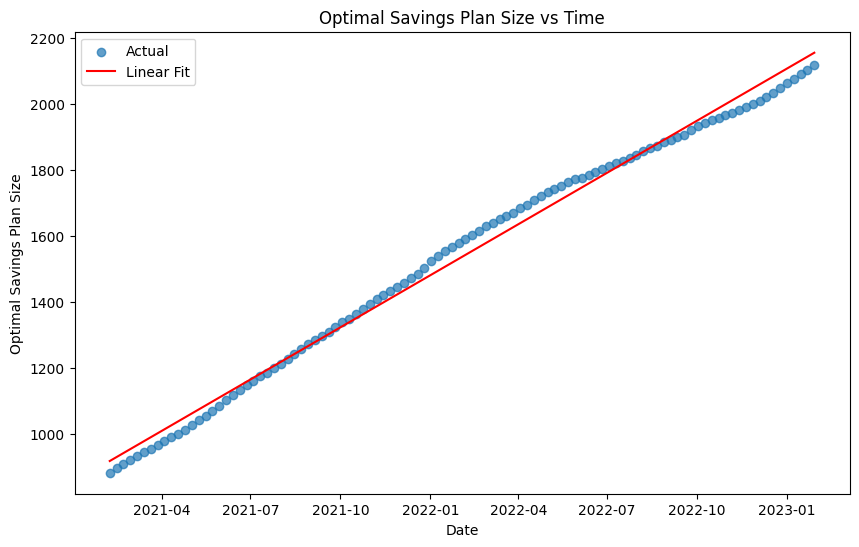

In [44]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Use time index t and optimal savings plan size R_t
time_index = np.arange(len(sundays_df)).reshape(-1, 1)
R = sundays_df['savings_plan_vms_year'].values

# Fit linear regression R_t ~ t
model = LinearRegression()
model.fit(time_index, R)
R_pred = model.predict(time_index)

# Print metrics
mse = mean_squared_error(R, R_pred)
mae = mean_absolute_error(R, R_pred)
r2 = r2_score(R, R_pred)

print(f"Model: R_t = m * t + c")
print(f"Slope (m): {model.coef_[0]:.4f}")
print(f"Intercept (c): {model.intercept_:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")

# Plot
plt.figure(figsize=(10,6))
plt.scatter(sundays_df['USAGE_DATE'], R, alpha=0.7, label='Actual')
plt.plot(sundays_df['USAGE_DATE'], R_pred, color='red', label='Linear Fit')
plt.title('Optimal Savings Plan Size vs Time')
plt.xlabel('Date')
plt.ylabel('Optimal Savings Plan Size')
plt.legend()
plt.show()




# Conclusion

Assuming the current growth trend persist, time seems to be a good prediction of the optimal 1-year plan.